# Bebossing detector
Dit notebook gaat in op het kunnen detecteren van bebossing vanuit satellietfoto's d.m.v. een semantic segmentation oplossing (U-Net).

# Contact
Gerrit van de Bunt (gerrit.vandebunt@student.hu.nl)\
Wail Abou (wail.abou@student.hu.nl)\
Wijnand van Dijk (wijnand.vandijk@student.hu.nl)

http://localhost:8888/notebooks/src/notebooks/unet.ipynb#Contact

# Initialisatie

In [ ]:
import os
import tensorflow as tf

In [1]:
# Download data if not present

if not os.path.exists('../data'):
    from python_scripts.onedrive_helper import *
    oh = OneDriveHelper()
    oh.download('data', '../')

In [2]:


gpu_amount = len(tf.config.experimental.list_physical_devices('GPU'))
print(f'GPU acceleration enabled = {gpu_amount > 0}')

GPU acceleration enabled = False


In [3]:
input_dir = "../data/Model Input Data/West_Bengal_15_geolocations_v2/true_colours_images_testset_v2"
target_dir = "../data/Model Input Data/West_Bengal_15_geolocations_v2/mask_completed"
img_size = (512, 512)
num_classes = 2
batch_size = 1

input_img_paths = sorted([
    os.path.join(input_dir, fname) 
    for fname in os.listdir(input_dir) 
    if fname.endswith(".png")])

target_img_paths = sorted([
    os.path.join(target_dir, fname)
    for fname in os.listdir(target_dir)
    if fname.endswith(".png") and not fname.startswith(".")])

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 56
../data/Model Input Data/West_Bengal_15_geolocations_v2/true_colours_images_testset_v2\86.99694333333332_21.886076666666664_87.04394333333333_21.93307666666666_2017-01-01_2018-01-01.png | ../data/Model Input Data/West_Bengal_15_geolocations_v2/mask_completed\86.99694333333332_21.886076666666664_87.04394333333333_21.93307666666666_2017-01-01_2018-01-01.png
../data/Model Input Data/West_Bengal_15_geolocations_v2/true_colours_images_testset_v2\86.99694333333332_21.886076666666664_87.04394333333333_21.93307666666666_2018-01-01_2019-01-01.png | ../data/Model Input Data/West_Bengal_15_geolocations_v2/mask_completed\86.99694333333332_21.886076666666664_87.04394333333333_21.93307666666666_2018-01-01_2019-01-01.png
../data/Model Input Data/West_Bengal_15_geolocations_v2/true_colours_images_testset_v2\86.99694333333332_21.886076666666664_87.04394333333333_21.93307666666666_2019-01-01_2020-01-01.png | ../data/Model Input Data/West_Bengal_15_geolocations_v2/mask_completed\86.

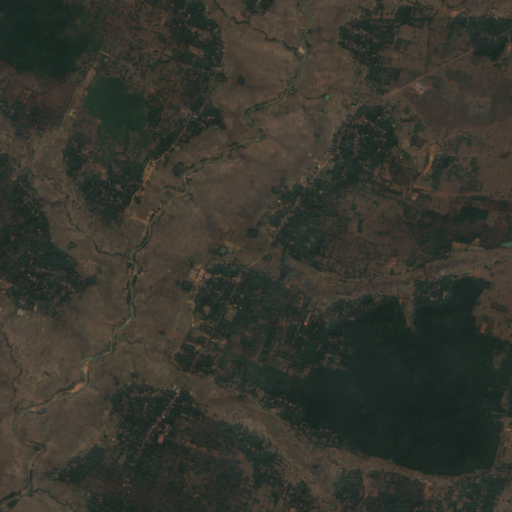

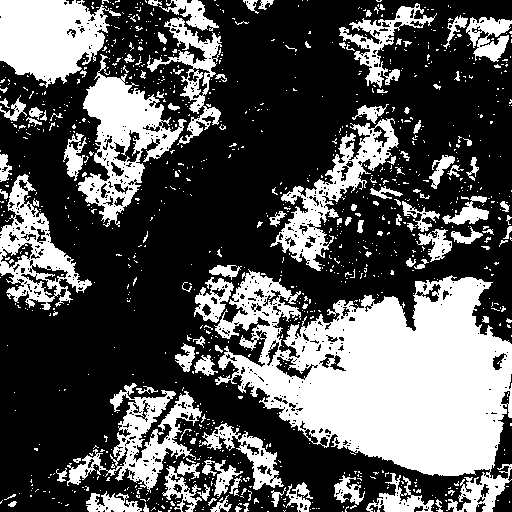

In [4]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps
from matplotlib import pyplot as plt
import random as rnd

i = rnd.randrange(0, len(input_img_paths) - 1)

# Displays random input image
display(Image(filename=input_img_paths[i]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[i]))
display(img)

In [5]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

class SatelliteImages(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size)
            data = np.array(img)[:, :, 0]
            data = np.expand_dims(data, 2)
            y[j] = data
            y[j] = np.divide(y[j], 255)
        return x, y

# Model


In [6]:
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [7]:
import random

# Split our img paths into a training and a validation set using 80/20 split
val_samples = int(len(input_img_paths) * 0.2)
seed = 1337
random.Random(seed).shuffle(input_img_paths)
random.Random(seed).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = SatelliteImages(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = SatelliteImages(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [8]:
# Custom Metric functions
def custom_pixel_accuracy(y_true, y_pred):
    """Returns the pixel accuracy between a given ground truth and a semantic segmentation mask.
    Please note that this metric is NOT robust; non-classified areas are also taken into account (if they exist).
    As such it works best when coupled with other metrics such as precision, recall and F1 score."""
    if y_true.shape[-1] != y_pred.shape[-1]:
        raise IndexException()
    dimensions = y_true.shape
    # Itereer over elke pixel in beide matrices (y_true, y_pred)
    # Kijk of er verschil is, zo nee, voeg 1 toe aan score
    # Retourneer score/totaal aantal pixels

In [9]:
# smpl_train = next(iter(train_gen))
# smpl_val = next(iter(val_gen))
# x_train, y_train, x_val, y_val = smpl_train[0], smpl_train[1], smpl_val[0], smpl_val[1]
# display(x_train.shape)
# display(y_train.shape)
# display(x_val.shape)
# display(y_val.shape)
# display(y_val[0][0][0].shape)

In [10]:
# test = y_val.copy()
# test = test.reshape((5,512,512))
# test2 = x_val.copy()
# test2.reshape((5,512,512,3))

In [11]:
# model_2 = get_model(img_size, num_classes)

# model_2.compile(optimizer="rmsprop", loss="binary_crossentropy")
# callbacks = [keras.callbacks.ModelCheckpoint("image_segmentation_test.h5", save_best_only=True)]

# epochs = 25
# reshistory_2 = model_2.fit(train_gen, epochs=epochs, callbacks=callbacks, validation_data=val_gen)

In [12]:
import packaging
import tensorflow
keras.__version__

'2.4.0'

In [29]:
class MeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self, y_true=None, y_pred=None, num_classes=None, name='mean_iou', dtype=None):
        super(MeanIoU, self).__init__(num_classes = num_classes, name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

In [30]:
# https://github.com/qubvel/segmentation_models/blob/master/segmentation_models/metrics.py

In [31]:
class Precision(tf.keras.metrics.Precision):
    def __init__(self, y_true=None, y_pred=None, name='precision', dtype=None):
        super(Precision, self).__init__(name=name, dtype=dtype)
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

In [35]:
class Recall(tf.keras.metrics.Recall):
    def __init__(self, y_true=None, y_pred=None, name='recall', dtype=None):
        super(Recall, self).__init__(name=name, dtype=dtype)
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

In [ ]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.

model = get_model(img_size, num_classes)

model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=[MeanIoU(num_classes=2), Precision(), Recall()])
# model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=[MeanIoU(num_classes=2)])
callbacks = [keras.callbacks.ModelCheckpoint("image_segmentation.h5", save_best_only=True)]

# Train the model, doing validation at the end of each epoch.
epochs = 25
reshistory = model.fit(train_gen, epochs=epochs, callbacks=callbacks, validation_data=val_gen)

Epoch 1/25
45/45 [==============================] - 66s 1s/step - loss: 1.0978 - mean_iou: 0.2391 - precision: 0.2365 - recall: 0.5175 - val_loss: 12.8789 - val_mean_iou: 0.1265 - val_precision: 0.2528 - val_recall: 0.9981
Epoch 2/25
45/45 [==============================] - 65s 1s/step - loss: 0.3673 - mean_iou: 0.2338 - precision: 0.1809 - recall: 0.3665 - val_loss: 0.7867 - val_mean_iou: 0.5717 - val_precision: 0.5758 - val_recall: 0.5568
Epoch 3/25
45/45 [==============================] - 67s 2s/step - loss: 0.3201 - mean_iou: 0.3034 - precision: 0.2392 - recall: 0.5273 - val_loss: 0.4921 - val_mean_iou: 0.1814 - val_precision: 0.2555 - val_recall: 0.8926
Epoch 4/25
45/45 [==============================] - 69s 2s/step - loss: 0.2946 - mean_iou: 0.2894 - precision: 0.2427 - recall: 0.5031 - val_loss: 0.4269 - val_mean_iou: 0.2542 - val_precision: 0.1612 - val_recall: 0.2910
Epoch 5/25
45/45 [==============================] - 76s 2s/step - loss: 0.2919 - mean_iou: 0.2755 - precision: 

In [ ]:
plt.plot(reshistory.history['loss'],label="train_loss")
plt.plot(reshistory.history['val_loss'],label="val_loss")
# plt.plot(reshistory.history['accuracy'],label="train_accuracy")
# plt.plot(reshistory.history['val_accuracy'],label="val_accuracy")
plt.legend()
plt.show()

In [ ]:
reshistory.history['loss']

In [ ]:
# Generate predictions for all images in the validation set

val_gen = SatelliteImages(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)

def return_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    return img


# Display results for validation image #0
i = rnd.randrange(0, len(val_input_img_paths) - 1)

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.

In [ ]:
# # Exporting images
# for i in range(len(val_input_img_paths)):
    

In [ ]:
# Hyperparameter optimalisation;
# Here we define a couple of variations of the model above with slight adjustments to the hyperparameters/structure
# The performance of these models is analysed to determine the best model architecture for our current problem.

In [15]:
def alt_model_1(img_size, num_classes):
    """Alternative model getter that emphasises on additional filters."""
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(64, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [128, 256, 512]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [512, 256, 128, 64]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


def alt_model_2(img_size, num_classes):
    """Alternate model getter that emphasises on a additional up/downsampling layer"""
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256, 512]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [512, 256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

In [16]:
# Model trialing.

models = [{"name":"baseline","model":get_model,"opt":"rmsprop"},
          {"name":"filters","model":alt_model_1,"opt":"rmsprop"},
          {"name":"up-downsampling","model":alt_model_2,"opt":"rmsprop"}]

In [18]:
def get_axes_row_col(index, cols):
    row = index // cols
    col = index % cols
    return row, col

In [19]:
history = []
for entry in models:
    ho_model = entry["model"](img_size, num_classes)
    ho_model.compile(optimizer=entry["opt"], loss="sparse_categorical_crossentropy", metrics=[MeanIoU(num_classes=2)])
    callbacks = [keras.callbacks.ModelCheckpoint("image_segmentation_{}.h5".format(entry["name"]), save_best_only = True)]
    outcome = ho_model.fit(train_gen, epochs=15, callbacks=callbacks, validation_data=val_gen)
    history.append(outcome.history)

Epoch 1/15


KeyboardInterrupt: 

In [20]:
def plot_model_history(metric, history, models):
    ncols = len(models)
    fig, ax = plt.subplots(nrows=1, ncols=ncols, squeeze=False)
    fig.set_size_inches(18.5, 10.5)
    
    for grid_indexor in range(len(models)):
        row, col = get_axes_row_col(grid_indexor, ncols)
        # Plot desired metric
        ax[row, col].plot(history[grid_indexor][metric], label=f"{entry['name']} train_loss")
        ax[row, col].plot(history[grid_indexor][f"val_{metric}"], label=f"{entry['name']} val_loss")
    
    plt.legend()
    plt.suptitle(f'History of {metric}', fontsize=20)
    plt.tight_layout()
    plt.show()

In [ ]:
plot_model_history('mean_iou', history, models)

In [ ]:
plot_model_history('loss', history, models)

In [ ]:
# plot_model_history('precision', history, models) TODO

In [ ]:
# plot_model_history('recall', history, models) TODO